In [ ]:
# Aim:

## Todo: JPG convert
## Todo: PNG convert

# Todo:
## Todo: select image quality
## Todo: multiprocessing

## Convertor

In [ ]:
# Vivek Kumar
# Initial ground work
# https://medium.com/@vivek8981/dicom-to-jpg-and-extract-all-patients-information-using-python-5e6dd1f1a07d
# but the images loss their contrast

In [57]:
import pydicom
import cv2
import pandas
import PIL
import numpy as np

In [51]:
from pathlib import Path
import os

folder_origin = Path('/Users/yukuo/Desktop/dicom_test')
folder_destination = Path('/Users/yukuo/Desktop/dicom_test_jpg')
dicom_file_list = []
# export_file_list = []

# read file
for root, sub_f, file in os.walk(folder_origin):
    for f in file:
        if f.endswith('dcm'):
            file_path_dcm = Path(root)/Path(f)
            file_path_exp =  folder_destination / Path(f).with_suffix('.jpg')
            # stor origin / destination
            dicom_file_list.append(file_path_dcm)
            # export_file_list.append(file_path_exp)

# sort the list
dicom_file_list.sort()


In [168]:
# Resolve the window/level/slope

dicom_file_list = dicom_file_list[:10]

for file_path in dicom_file_list:
    # read images and their pixel data
    ds = pydicom.dcmread(file_path, force=True)
    # # Convert pixel_array (img) to -> gray image (img_2d_scaled)
    pixel_array = ds.pixel_array.astype(float)  # preparing for scaling
    
    
    
    # rescale slope, rescale intercept, adjust window and level
    rescale_slope = int(ds.RescaleSlope)
    rescale_intercept = int(ds.RescaleIntercept)
    window_center = int(ds.WindowCenter)
    window_width = int(ds.WindowWidth)
    
    pixel_array_scaled = (pixel_array)*rescale_slope+rescale_intercept

    # xxx=np.piecewise(x, [condition1,condition2], [func1,func2])
    # already 
    def get_LUT_value(data, window, level):
        return np.piecewise(data, 
            [data <= (level - 0.5 - (window-1)/2),
                data > (level - 0.5 + (window-1)/2)],
                [0, 255, lambda data: ((data - (level - 0.5))/(window-1) + 0.5)*(255-0)])

    pixel_array_scaled = get_LUT_value(pixel_array_scaled, window_width, window_center)
    
    # Conver to uint8 (8-bit unsigned integer), for image to save/display
    # pixel_array_scaled = np.uint8(pixel_array)
    # Already done?
    
    # pixel_array_scaled = cv2.convertScaleAbs(pixel_array-np.min(pixel_array), alpha=(255.0 / min(np.max(pixel_array)-np.min(pixel_array), 10000)))
    # pixel_array_scaled = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
    
    # used in XRAY
    # pixel_array_scaled = (np.maximum(pixel_array, 0) / pixel_array.max()) * 255
    
    # export filepath/filename = folder_destination / full_file_name.dcm -> jpg
    full_export_fp_fn = folder_destination / file_path.with_suffix('.jpg').name

    # make dir
    Path.mkdir(full_export_fp_fn.parent, exist_ok=True)

    cv2.imwrite(str(full_export_fp_fn), pixel_array_scaled)
    



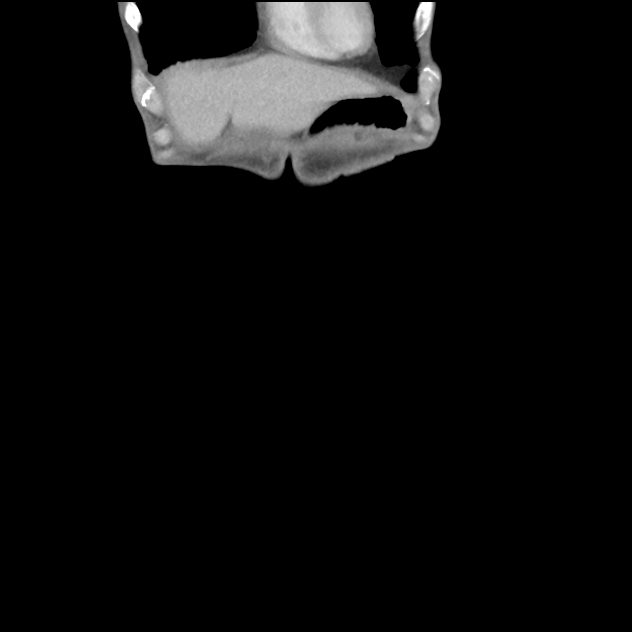

In [213]:
from matplotlib import pyplot as plt
ds = pydicom.dcmread(dicom_file_list[7], force=True)
pixel_array = ds.pixel_array.astype(float)  

# pixel_array = (pixel_array)*rescale_slope+rescale_intercept


# window center/level conversion function
# https://stackoverflow.com/questions/44924335/converting-12-bit-dicom-image-to-8-bit-jpeg
# http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.11.2.html#sect_C.11.2.1.2
def get_LUT_value(data, window, level):
    return np.piecewise(data, 
        [data <= (level - 0.5 - (window-1)/2),
            data > (level - 0.5 + (window-1)/2)],
            [0, 255, lambda data: ((data - (level - 0.5))/(window-1) + 0.5)*(255-0)])
pixel_array = get_LUT_value(pixel_array, window_width, window_center)

pixel_array =  (np.maximum(pixel_array, 0) / pixel_array.max()) * 255
#pixel_array = cv2.convertScaleAbs(pixel_array-window_center, alpha=(255.0/window_width))

display(Image.fromarray(np.uint8(pixel_array)))

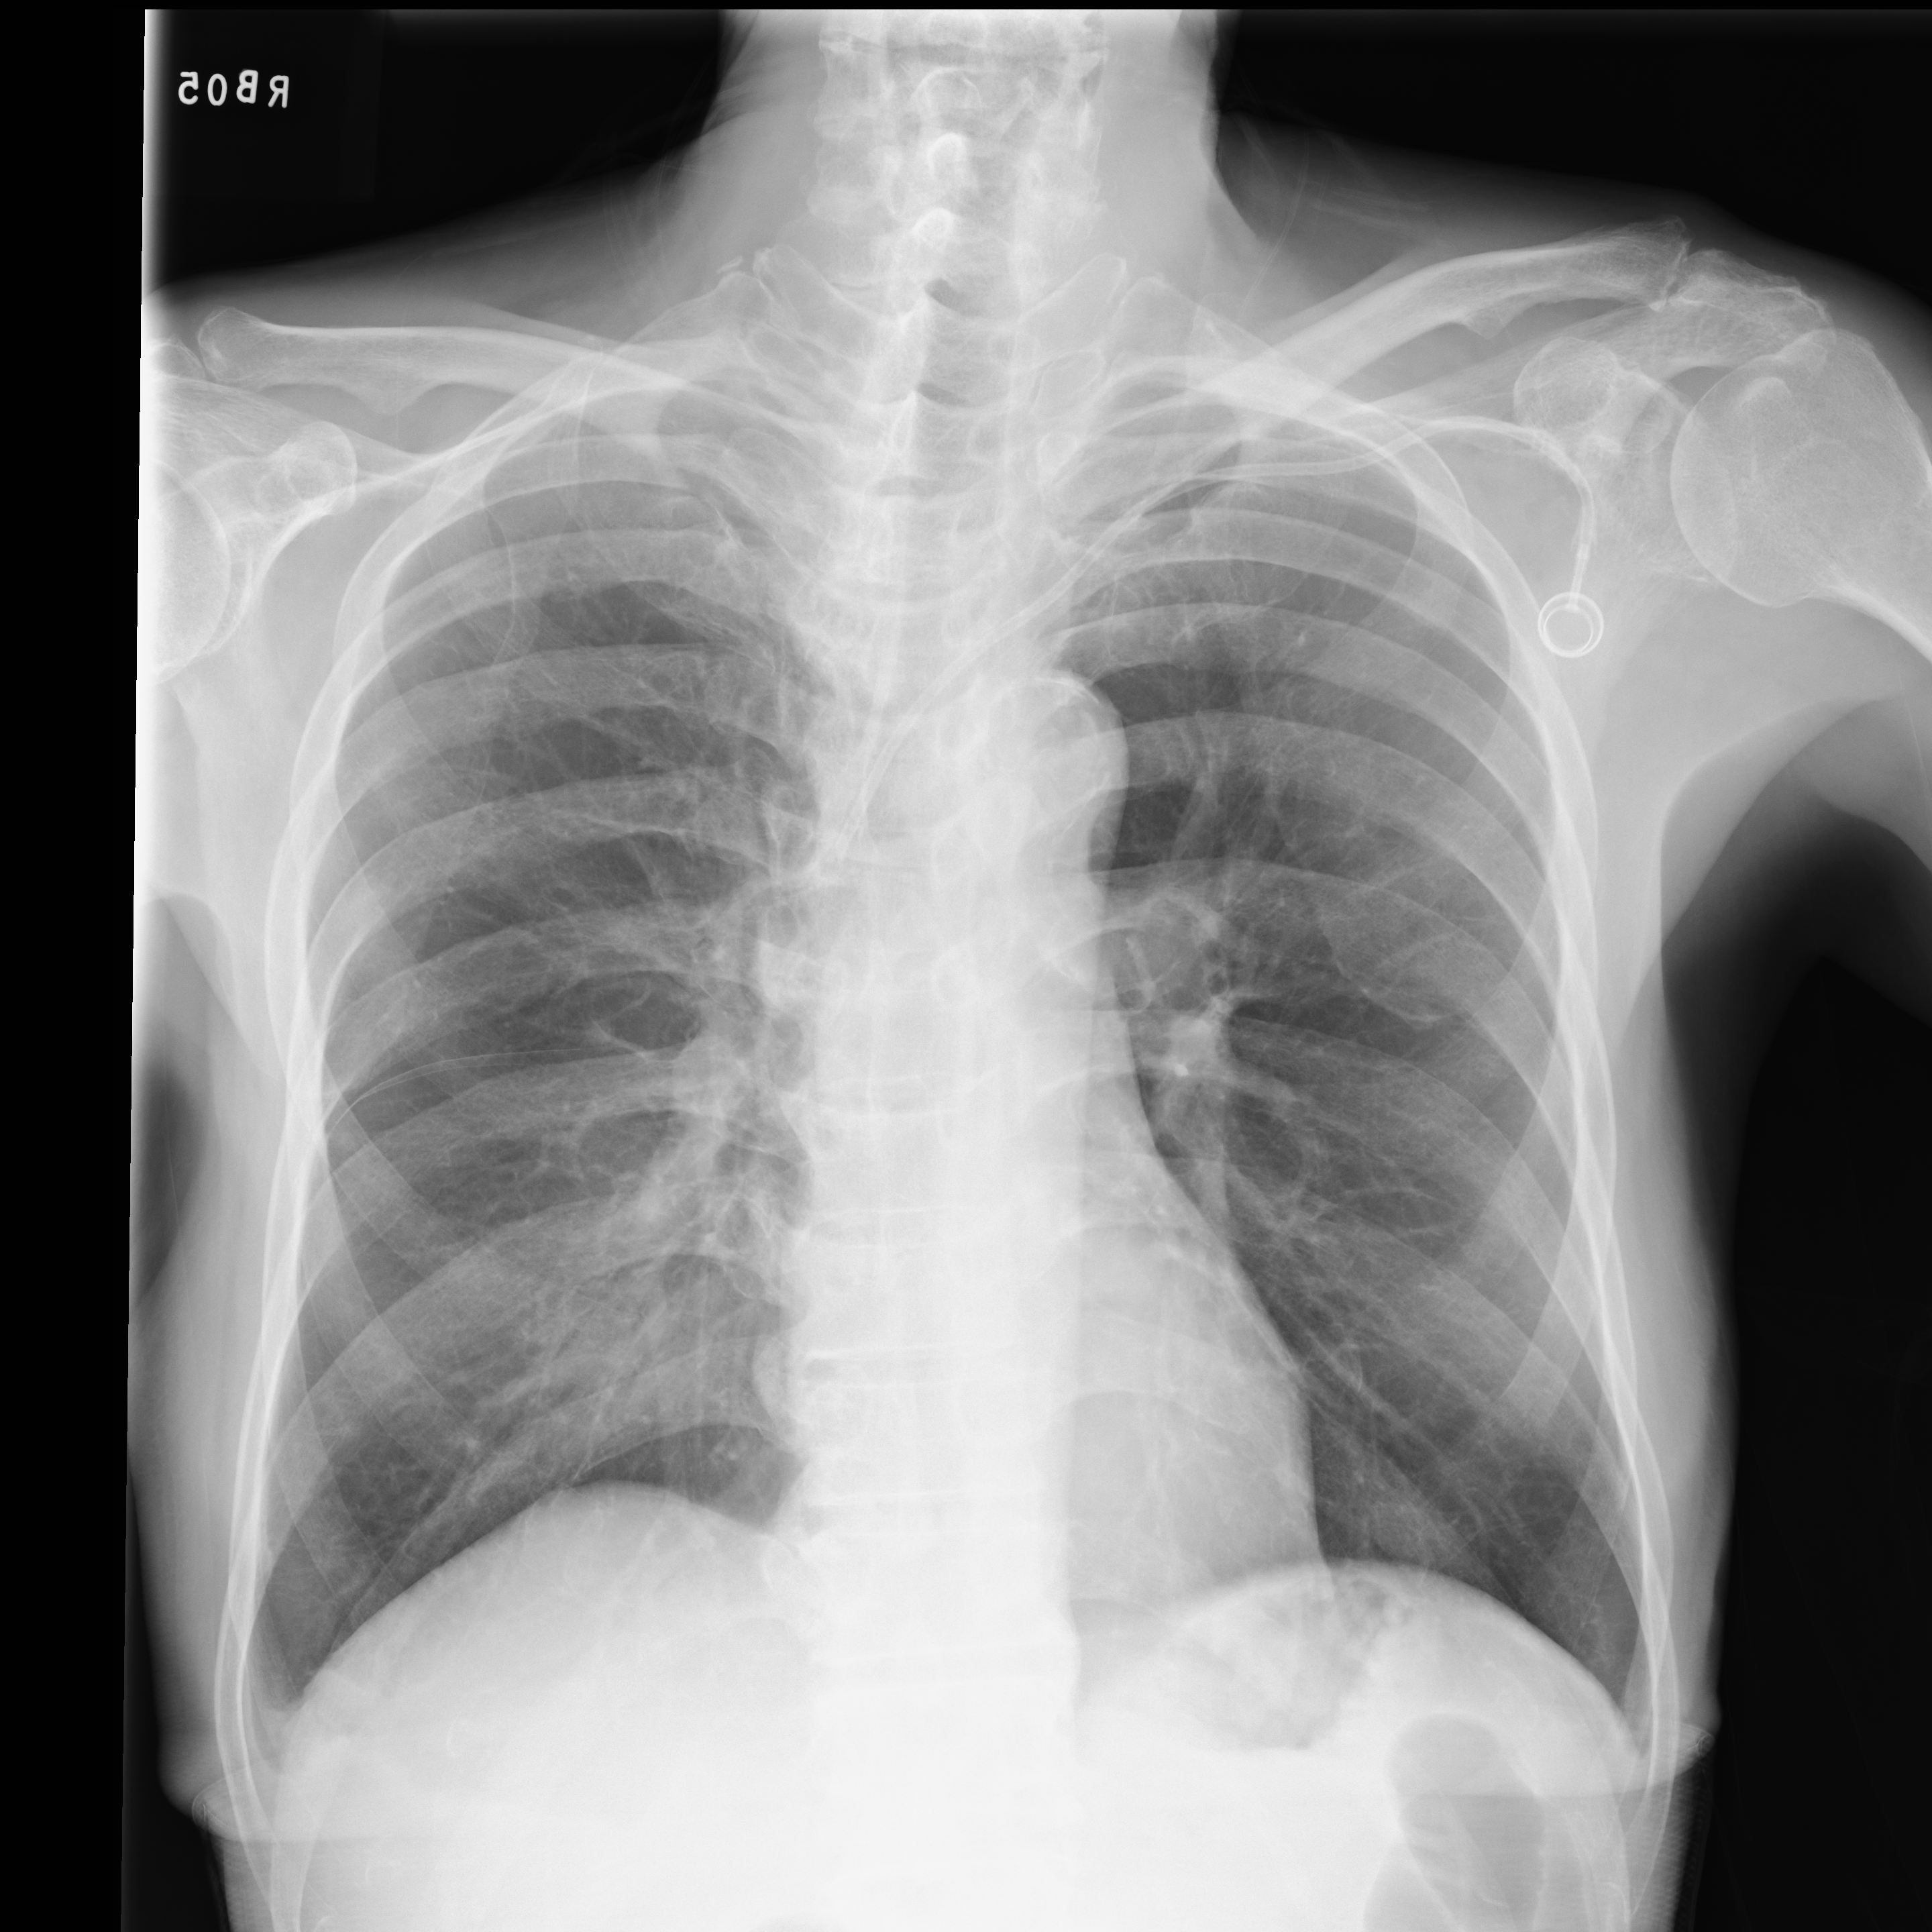

In [208]:
# use this in XRAY

from matplotlib import pyplot as plt
ds = pydicom.dcmread(dicom_file_list[0], force=True)
pixel_array = ds.pixel_array.astype(float)  


# pixel_array = cv2.convertScaleAbs(pixel_array-np.min(pixel_array), alpha=(255.0 / min(np.max(pixel_array)-np.min(pixel_array), 10000)))
# pixel_array = ((pixel_array-pixel_array.min())/(pixel_array.max()-pixel_array.min())) * 255.0
pixel_array =  (np.maximum(pixel_array, 0) / pixel_array.max()) * 255


# the use of Presentation LUT Shape == 'INVERSE' or PhotometricInterpretation == "MONOCHROME1"
# https://groups.google.com/g/comp.protocols.dicom/c/Wzt_06RbF5c?pli=1
# Presentation LUT Shape is mandatory in the DX Image Module
# Bottom line: both MONOCHROME2/IDENTITY and MONOCHROME1/INVERSE result in an output image where 0 is black and the maximum value is white (i.e. P-Values).
try:
    inverse_sign = -1 if ds.PresentationLUTShape=='INVERSE' else 1
except:
    inverse_sign = 1
pixel_array = inverse_sign * pixel_array
display(Image.fromarray(np.uint8(pixel_array)))

In [61]:
np.uint8(pixel_array_scaled)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [54]:
# But the contrast and 

dicom_file_list = dicom_file_list[:10]

for file_path in dicom_file_list:
    # read images and their pixel data
    ds = pydicom.dcmread(file_path)
    pixel_array = ds.pixel_array

    # export filepath/filename = folder_destination / full_file_name.dcm -> jpg
    full_export_fp_fn = folder_destination / file_path.with_suffix('.jpg').name

    # make dir
    Path.mkdir(full_export_fp_fn.parent, exist_ok=True)
    
    # export image
    cv2.imwrite(str(full_export_fp_fn), pixel_array)
    


In [2]:
from pydicom import dcmread
from pydicom.data import get_testdata_file

ds = dcmread(get_testdata_file('JPEG-LL.dcm'))
arr = ds.pixel_array

## Multiprocessing

In [1]:
import multiprocessing
cpus = multiprocessing.cpu_count()
cpus

8